In [1]:
from typing import List, Tuple, Dict
import numpy as np
from matplotlib import pyplot as plt
from mne import time_frequency, create_info, EpochsArray
from scipy import signal
import seaborn as sns
# fooof
from fooof import FOOOF
from fooof.plts.spectra import plot_spectrum

In [3]:
import sys
sys.path.insert(0, r'C:\Users\camil\Documents\int\EphysVibe\ephysvibe')
from trials import select_trials

In [4]:
lip_path = r"C:\Users\camil\Documents\int\data\openephys\test_results\lip\2022-11-22_10-59-03_Riesling_lip_e1_r1.npy"
lip_f = np.load(lip_path, allow_pickle=True).item(0)
sp_lip = lip_f["sp_data"]
bhv_lip = lip_f["bhv"]
print('sp_lip keys:')
print(sp_lip.keys())
print('bhv_py trial keys:')
print(bhv_lip[0].keys())

sp_lip keys:
dict_keys(['sp_samples', 'blocks', 'code_numbers', 'code_samples', 'eyes_values', 'lfp_values', 'samples', 'clusters_id', 'clusters_ch', 'clustersgroup', 'clusterdepth'])
bhv_py trial keys:
dict_keys(['trial', 'AbsoluteTrialStartTime', 'Btn1', 'Btn10', 'Btn2', 'Btn3', 'Btn4', 'Btn5', 'Btn6', 'Btn7', 'Btn8', 'Btn9', 'Eye', 'Eye2', 'EyeExtra', 'Gen1', 'Gen10', 'Gen11', 'Gen12', 'Gen13', 'Gen14', 'Gen15', 'Gen16', 'Gen2', 'Gen3', 'Gen4', 'Gen5', 'Gen6', 'Gen7', 'Gen8', 'Gen9', 'Joystick', 'Joystick2', 'KeyInput', 'Mouse', 'PhotoDiode', 'SampleInterval', 'Touch', 'CodeNumbers', 'CodeTimes', 'Block', 'BlockCount', 'Condition', 'CycleRate', 'Angle', 'BackgroundColor', 'Info', 'Position1', 'Position2', 'Position3', 'Position4', 'Position5', 'Position6', 'Scale', 'Status', 'Time', 'Zorder', 'ReactionTime', 'EndTimes', 'StartTimes', 'Attribute11', 'Attribute12', 'Attribute13', 'Attribute21', 'Attribute22', 'Attribute23', 'Attribute24', 'Attribute25', 'Attribute26', 'Code', 'FrameBy

In [35]:
# load v4
v4_path = r"C:\Users\camil\Documents\int\data\openephys\test_results\lip\2022-11-22_10-59-03_Riesling_v4_e1_r1.npy"
v4_f = np.load(v4_path, allow_pickle=True).item(0)
sp_v4 = v4_f["sp_data"]
bhv_v4 = v4_f["bhv"]

In [36]:
def align_lfp_with_event(sp_py:Dict,trials_idx:np.ndarray,t_after:float,t_before:float,fs:int,event:str)->Tuple[np.ndarray,np.ndarray]:
    n_samples = int((t_after-t_before)*fs)
    lfp_aligned = []
    samples_aligned = []
    for n_trial in trials_idx:
        idx_event = np.where(sp_py["code_numbers"][n_trial] == event)[0]# index when the event occurs
        sample_event = sp_py["code_samples"][n_trial][idx_event] # sample when the event occurs
        # Shift samples to align with event
        samples_shift = sp_py['samples'][n_trial] - sample_event
        # cut samples and lfps
        idx_cut = np.where(np.logical_and(samples_shift>= t_before * fs,samples_shift<t_after*fs))[0]
        # append results
        samples_aligned.append(samples_shift[idx_cut])
        lfp_aligned.append(sp_py['lfp_values'][n_trial][:,idx_cut])
    return np.stack(samples_aligned),np.stack(lfp_aligned)

#### Align lfps with an event and cut

In [37]:
lfp_concat = np.concatenate(sp_lip['lfp_values'],axis=1)

In [38]:
n_block = 2
trials_idx = select_trials.select_trials_block(sp_lip,n_block)
trials_idx = select_trials.select_correct_trials(bhv_lip,trials_idx)

Number of trials in block 2: 104
Number of correct trials in block 2: 80


In [39]:
target_on = 37
event = target_on
t_before = -0.2
t_after = 1
fs = 30000

In [42]:
lip_samples_aligned,lip_lfp_aligned = align_lfp_with_event(sp_lip,trials_idx,t_after,t_before,fs,event)
v4_samples_aligned,v4_lfp_aligned = align_lfp_with_event(sp_v4,trials_idx,t_after,t_before,fs,event)

In [43]:
lip_all_channels = np.arange(lip_lfp_aligned.shape[1])
print(lip_all_channels[-1]+1)
v4_all_channels = np.arange(v4_lfp_aligned.shape[1])
print(v4_all_channels[-1]+1)

32
64


In [44]:
np.mean(v4_lfp_aligned,axis=1).shape

(80, 1200)

In [45]:
# Use v4 as reference
v4_chs_mean = np.mean(v4_lfp_aligned,axis=1)
for ch in lip_all_channels:
    #if ch != ch_out:
    lip_lfp_aligned[:,ch]=lip_lfp_aligned[:,ch]-v4_chs_mean
channels = lip_all_channels#[:-1]
#lfp_aligned =lfp_aligned[:,channels]

In [26]:
lfp_concat.shape

(32, 5291063)

In [50]:
lfp_concat.shape

(32, 5291063)

In [51]:
sp_lip["code_samples"][0]/30

array([823752.76666667, 823767.36666667, 823905.86666667, 824261.46666667,
       824262.93333333, 824379.13333333, 825391.        , 825702.83333333,
       826004.93333333, 826014.6       , 826073.43333333, 826278.83333333,
       826279.26666667])

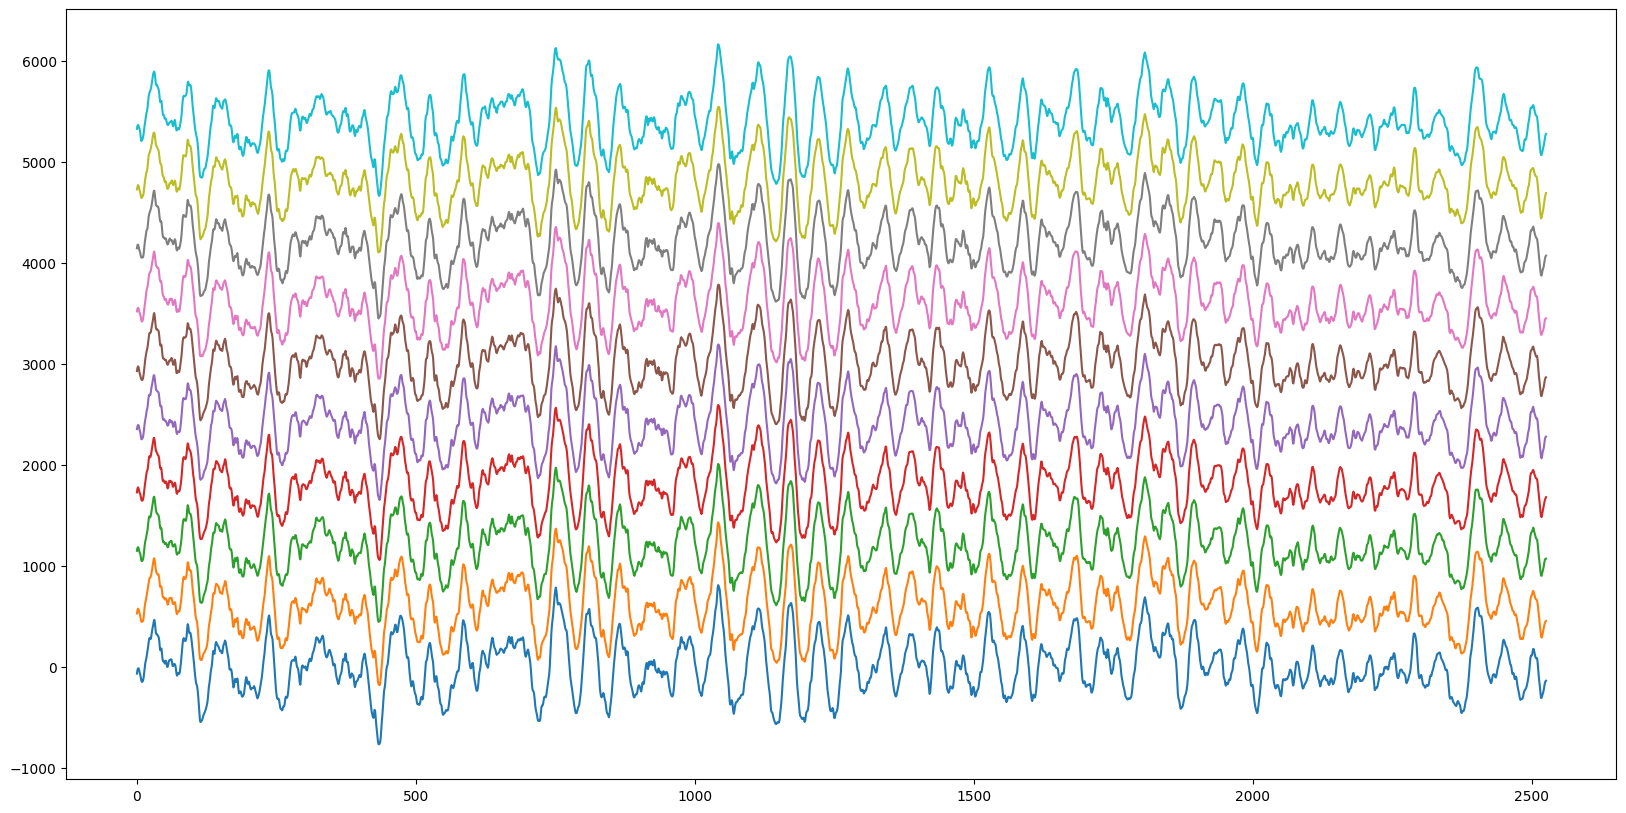

In [52]:
fig,ax = plt.subplots(figsize=(20,10))
a=plt.plot(lfp_concat[0:10,823752:826279].T+np.arange(0,6000,600))

In [55]:
filter_lfp_concat = filter_lfp(lfp_concat)

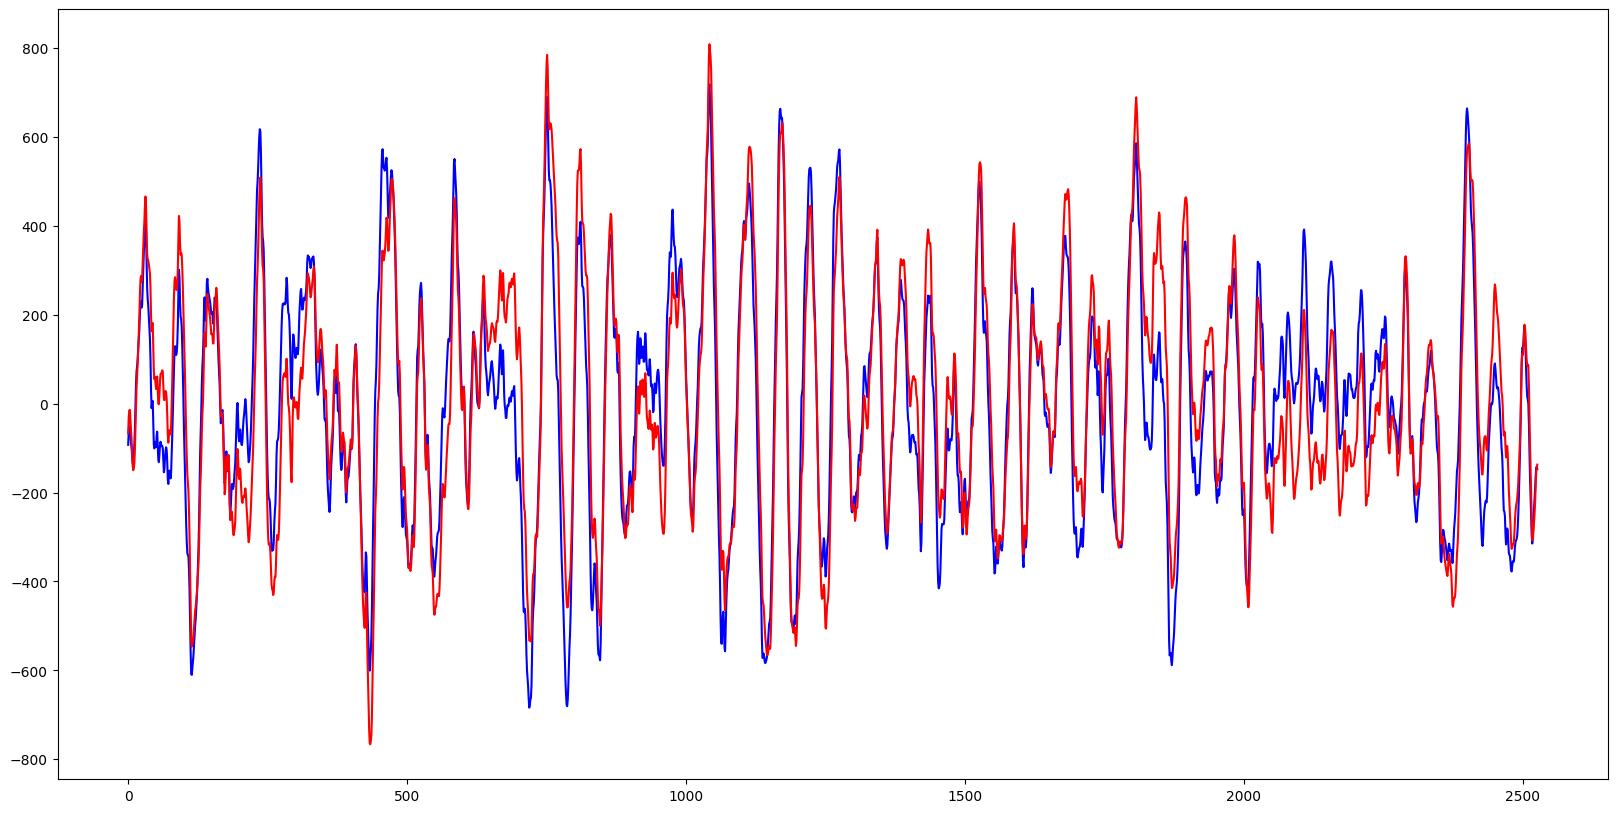

In [62]:
fig,ax = plt.subplots(figsize=(20,10))
a=plt.plot(filter_lfp_concat[0,823752:826279].T,color='b')#+np.arange(0,6000,600))
a=plt.plot(lfp_concat[0,823752:826279].T,color='r')#+np.arange(0,6000,600))

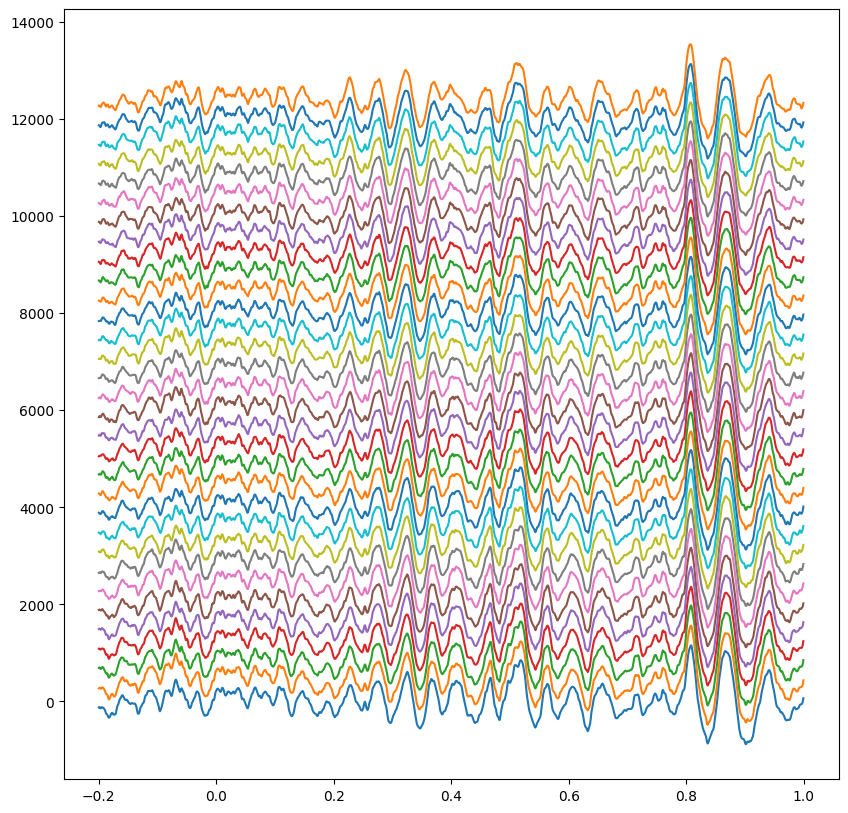

In [58]:
fig,ax = plt.subplots(figsize=(10,10))
a=plt.plot(lip_samples_aligned[0]/fs,lip_lfp_aligned[0].T+np.arange(0,12800,400))

In [54]:
def filter_lfp(lfps):
    """Basic filtering of the continuous LFP before cutting it into epochs.
    The signal is expected to be already low-pass filtered at 250Hz
    """
    fs_lfp = 1000  # sampling frequency of the LFP signal in Hz
    fc_hp = 1  # cut-off frequency of the high pass filter in Hz
    fc_notch = [
        49.5,
        50.5,
    ]  # band of frequencies to be attenuated in the notch filter in Hz

    # perform a High pass filter - butterworth filter of order 6 at 1Hz
    sos = signal.butter(6, fc_hp, "hp", fs=fs_lfp, output="sos")
    LFP_hp = signal.sosfilt(sos, lfps)

    # perform a Notch filter of order 4 at 50 Hz
    sos_notch = signal.butter(4, fc_notch, "bandstop", fs=fs_lfp, output="sos")
    lfp_nf = signal.sosfilt(sos_notch, LFP_hp)

    return lfp_nf

In [15]:
lfp_nf= filter_lfp(lip_lfp_aligned)

In [23]:
lfp= lfp_nf#lfp_aligned

In [24]:
print("Number of channels: %d"%(channels.shape[0]))
print("Trials: %d, channels: %d, timestamps: %d"%(lfp.shape[0],lfp.shape[1],lfp.shape[2]))

Number of channels: 32
Trials: 80, channels: 32, timestamps: 1200


In [25]:
ch_name = 'PMd'
# Select the channels that contain ch_name in their name
channel_mask_PMd = np.array([True]*lip_lfp_aligned.shape[1])#np.array([False if channel.find(ch_name) == -1 else True for channel in channels])

In [26]:
print("Number of %s channels: %d"%(ch_name,channels[channel_mask_PMd].shape[0]))

Number of PMd channels: 32


In [27]:
# ignore if you don't want to zero pad
# zero padding each trial
n_zeros = lfp.shape[2]
lfps_pad = np.pad(lfp, ((0, 0),(0, 0),(n_zeros, n_zeros)), 'constant', constant_values=(0, 0))
lfps=lfps_pad
print("Shape lfps: (%s,%s,%s)"%lfps.shape)

Shape lfps: (80,32,3600)


In [64]:
# Compute the psd using welch
s_freq = 1000 # Hz
w_size = 250
psd_welch_1, freqs_welch_1 = time_frequency.psd_array_welch(lfps,fmin=1,fmax=100,sfreq=s_freq,n_per_seg=w_size)
#psd_multitaper_1, freqs_multitaper_1 = time_frequency.psd_array_multitaper(lfps,fmin=1,fmax=100,sfreq=1000,output='power',bandwidth=5)
print("Spectrum shape: (%s,%s,%s)"%psd_welch_1.shape)
print("Number of freqs: %d"%freqs_welch_1.shape[0])

NameError: name 'lfps' is not defined

In [69]:

f_psd_welch_1, f_freqs_welch_1 = time_frequency.psd_array_welch(filter_lfp_concat[0,823752:830279],fmin=1,fmax=100,sfreq=s_freq,n_per_seg=w_size)

Effective window size : 0.256 (s)


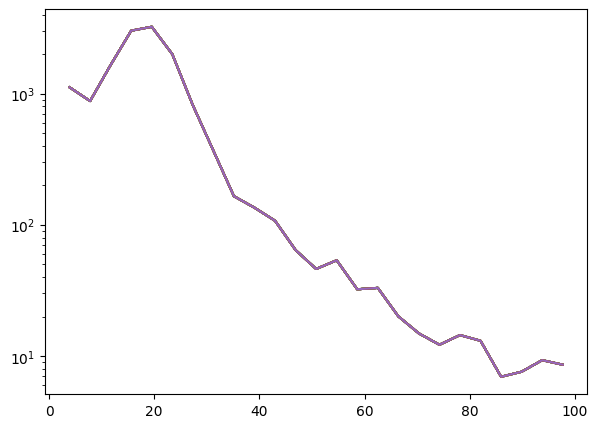

In [70]:
# print the mean power spectrum for each channel (mean across trials)
_,ax = plt.subplots(figsize=(7,5))
for i in range(f_psd_welch_1.shape[0]):
    plt.semilogy(f_freqs_welch_1,f_psd_welch_1)
plt.show()

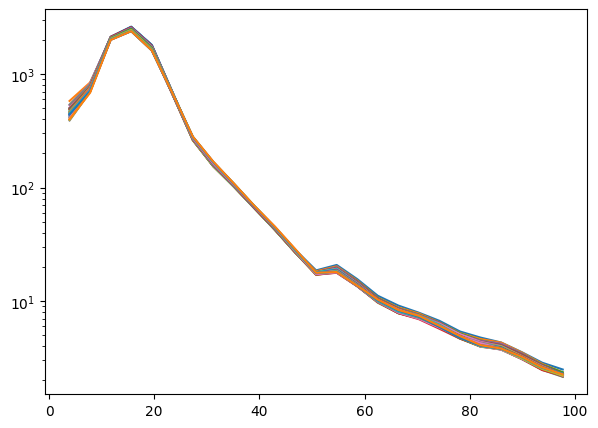

In [29]:
# print the mean power spectrum for each channel (mean across trials)
_,ax = plt.subplots(figsize=(7,5))
for i in range(psd_welch_1.mean(axis=(0)).shape[0]):
    plt.semilogy(freqs_welch_1,psd_welch_1.mean(axis=(0))[i])
plt.show()

In [30]:
plt.close('all')

In [31]:
# Initialize FOOOF object
fm = FOOOF()
# Define frequency range across which to model the spectrum
freq_range = [1, 100]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 3.91 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 98 Hz                        
                                 Frequency Resolution is 3.91 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offs

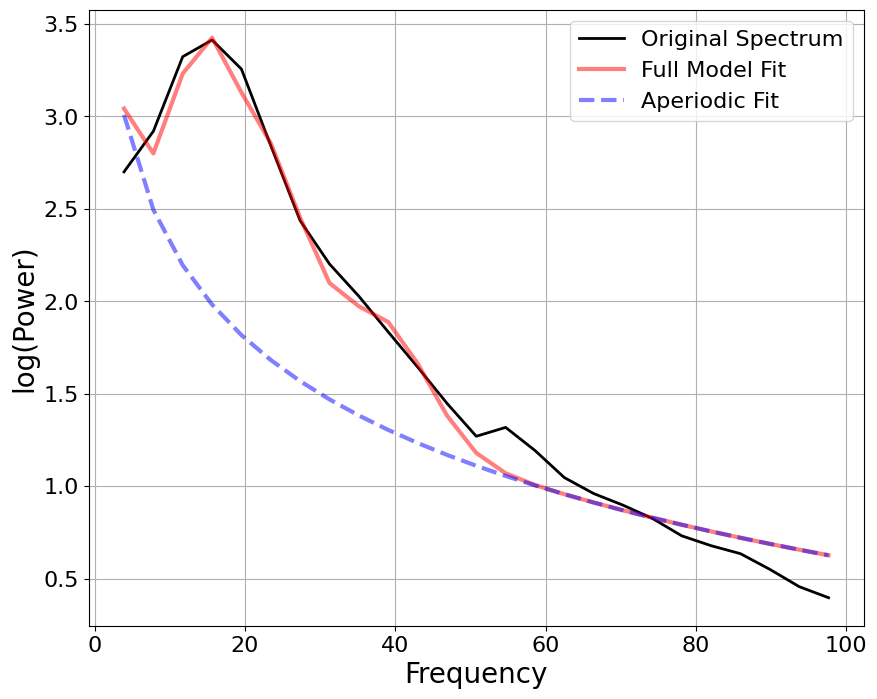

In [32]:
# Report: fit the model, print the resulting parameters, and plot the reconstruction
channel=0
fm.report(freqs_welch_1, psd_welch_1.mean(axis=(0))[channel],freq_range)

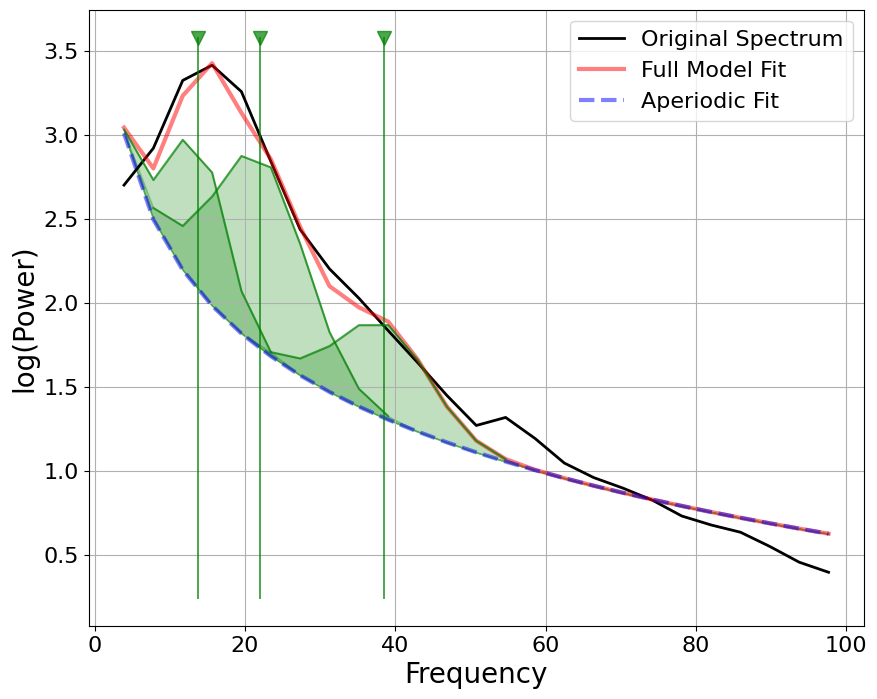

In [33]:
# Combine peak representations
fm.plot(plot_aperiodic=True, plot_peaks='line-shade-outline', plt_log=False)

In [98]:
# fit fooof for all channels and trials
def get_foof_param(channels_idx,psd_welch_1,freqs_welch_1):
    ch_param = []

    for ch in channels_idx:
        for trial in range(psd_welch_1.shape[0]):
            p=fm.fit(freqs_welch_1, psd_welch_1[trial,ch])
            ch_param.append(fm.peak_params_[:,0])
    return ch_param

In [99]:
params = []
for ch in channels:
    c_params = np.concatenate(get_foof_param(np.array([ch]),psd_welch_1,freqs_welch_1))
    params.append(c_params)


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 3.91 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 3.91 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 3.91 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a low

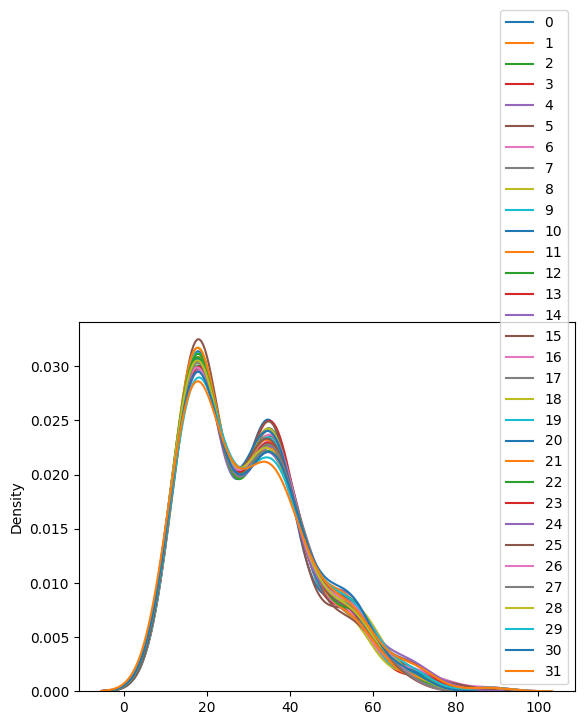

In [100]:

for ch in channels:
    sns.kdeplot(params[ch])
plt.legend(channels)
    


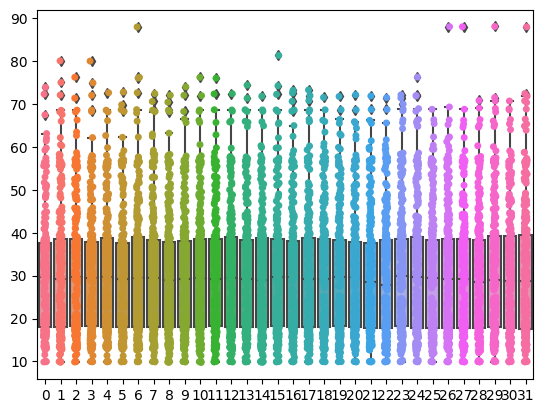

In [101]:
sns.boxplot(data=params)
ax = sns.stripplot(data=params)
plt.show()

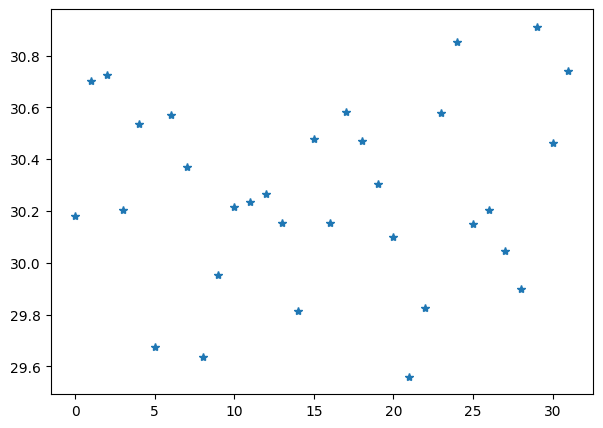

In [102]:
_,ax = plt.subplots(figsize=(7,5))
mean_array=[]
for ch in channels:
    mean_array.append(np.mean(params[ch]))

plt.plot(mean_array,'*')
plt.show()